In [145]:
import numpy as np
import pandas as pd
%matplotlib inline

In [92]:
otto_train = pd.read_csv('./train.csv/train.csv', index_col='id'); otto_train.shape

(61878, 94)

In [93]:
%run scripts/helper.py

In [94]:
# include all features in the model
otto_X = otto_train[otto_train.columns[:-1]].values

In [95]:
otto_y = get_encoded_labels(get_response(otto_train, 'target'))

In [218]:
train_idx, test_idx = get_stratified_shuffle_splits(otto_y, n_iter=3, train_size=20000, random_state=144)

In [219]:
X_train = otto_X[train_idx]
y_train = otto_y[train_idx]

In [220]:
from sklearn.cross_validation import train_test_split

Xt, Xv, yt, yv = train_test_split(X_train, y_train, test_size=0.2, random_state=12)

In [221]:
from sklearn.linear_model import LogisticRegression

In [222]:
classLogit = LogisticRegression(C=.1, class_weight=None, fit_intercept=True, multi_class='ovr', solver='lbfgs')

In [223]:
classLogit.fit(Xt, yt)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0)

In [224]:
predicted = classLogit.predict_proba(Xt)

In [225]:
print ('score on training set is %f' %(classLogit.score(Xt, yt)))

score on training set is 0.760625


In [226]:
from sklearn.metrics import log_loss
print (log_loss(yt, predicted))

0.648449161745


In [227]:
print ('score on testing set is %f' %(classLogit.score(Xv, yv)))

score on testing set is 0.742814


In [228]:
predictTest = classLogit.predict_proba(Xv)
print ('Log loss on the test set is {0}'.format(log_loss(yv, predictTest)))

Log loss on the test set is 0.683274300146


In [229]:
# lets print out the confusion matrix on the test set
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(yv, classLogit.predict(Xv))
print (cm)

[[ 37  22   1   0   0  13   2  14  29]
 [  0 938  78   3   7   0   5   3   4]
 [  0 391 123   5   0   1  11   2   0]
 [  0 130  14  38   0   6   2   0   0]
 [  0  10   0   0 160   0   0   1   1]
 [  4  17   3   1   0 869   5  16  23]
 [  4  41   6   1   2  24  86  18   1]
 [ 10  15   2   0   0  16   4 462  11]
 [  6  18   0   0   0  14   3   9 259]]


In [230]:
%run scripts/visualization.py

In [231]:
target_names = ['Class_' + str(idx) for idx in range(1, 10)]

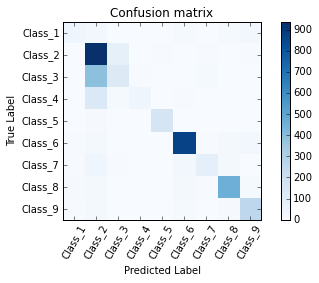

In [232]:
plot_confusion(cm, target_names)

In [233]:
# cross validation
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(classLogit, Xt, yt, cv=5, scoring='log_loss')

In [234]:
scores.min(), scores.mean(), scores.max()

(-0.71897230832989312, -0.68740630102698153, -0.64990986410797402)

### Automated parameter tuning

In [235]:
from sklearn.grid_search import GridSearchCV

In [236]:
logreg = LogisticRegression()
params = {
    'C': np.logspace(-2, 0, 3),
    'multi_class': ['ovr', 'multinomial'],
    'solver': ['lbfgs']
}

gs = GridSearchCV(logreg, params, cv=5, scoring='log_loss')
gs.fit(Xt, yt)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'multi_class': ['ovr', 'multinomial'], 'C': array([ 0.01,  0.1 ,  1.  ]), 'solver': ['lbfgs']},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='log_loss', verbose=0)

In [237]:
# lets sort the models by mean validation score
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)

[mean: -0.68741, std: 0.02324, params: {'multi_class': 'ovr', 'C': 0.10000000000000001, 'solver': 'lbfgs'},
 mean: -0.68910, std: 0.02551, params: {'multi_class': 'ovr', 'C': 1.0, 'solver': 'lbfgs'},
 mean: -0.70360, std: 0.01813, params: {'multi_class': 'ovr', 'C': 0.01, 'solver': 'lbfgs'},
 mean: -1.47924, std: 0.00411, params: {'multi_class': 'multinomial', 'C': 0.01, 'solver': 'lbfgs'},
 mean: -1.51435, std: 0.00854, params: {'multi_class': 'multinomial', 'C': 0.10000000000000001, 'solver': 'lbfgs'},
 mean: -1.52793, std: 0.01023, params: {'multi_class': 'multinomial', 'C': 1.0, 'solver': 'lbfgs'}]

In [238]:
gs.best_score_

-0.68740735206819836

In [239]:
gs.best_params_

{'C': 0.10000000000000001, 'multi_class': 'ovr', 'solver': 'lbfgs'}

In [240]:
logregFinal = LogisticRegression(C=.1, multi_class='ovr', solver='lbfgs')

In [241]:
logregFinal.fit(Xt, yt)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0)

In [242]:
print 'Log loss score on training set ', log_loss(yt, logregFinal.predict_proba(Xt))

Log loss score on training set  0.648449161745


In [243]:
print 'score on training set ', logregFinal.score(Xt, yt)

score on training set  0.760625


In [244]:
print 'score on test set ', logregFinal.score(Xv, yv)

score on test set  0.742814296426


In [245]:
print 'Log loss score on test set ', log_loss(yv, logregFinal.predict_proba(Xv))

Log loss score on test set  0.683274300146
